Modeling Biochemical Processes - Stochastic Simulation Algorithm
<html>
    <summary></summary>
         <div> <p></p> </div>
         <div style="font-size: 20px; width: 800px;"> 
              <h1>
               <left>Stochastic Simulation Algorithm</left>
              </h1>
              <p><left>============================================================================</left> </p>
<pre>Course: BIOM 421, Spring 2024
Instructor: Brian Munsky
Authors: Dr. Lisa Weber, Dr. Michael May, Joshua Cook, Brian Munsky
Contact Info: munsky@colostate.edu
</pre>
         </div>
    </p>

</html>

<details>
  <summary>Copyright info</summary>

```
Copyright 2024 Brian Munsky

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>



----------
## Learning Objectives for this Notebook:
--------------

After completing this notebook, students should:
* Be familiar with stochasticity and examples of stochasticity in biological systems.
* Be able to identify and set up stochiometery vectors and propensity functions for biological models.
* Be able to set up and use the stochastic simmulation algorithm
* Understand how reaction constants affect SSA trajectories
* Use stochastic simulations to create distributions for at specific time points for a model

# Introduction and Motivation

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎001.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎002.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎003.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎004.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎005.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎006.png)

# The Markov Description of Gene Regulation Dynamics.

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎007.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎008.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎009.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎010.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎011.png)

# The Stochastic Simulation Algorithm

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎012.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎013.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎014.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎015.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎016.png)

![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎017.png)

# Python Examples

In [52]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint

import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
figSize=600


## Example 1 - Bursting Gene Expression
Define the parameters, stoichiometry matrix, and propensity functions for a simple example model. In this case we will examine the bursting gene expression model (Example 2 in the Notebook M5A.)

![alt text](Figures/StoichiometryAndPropensity_2023/Slide29.png)

### Stoichiometries and Propensity Functions

In [31]:
# Note - This code is copied exactly from the previous Module M5A.  We are going to use the same steps as
# before to define the model.  The only difference is that we are going to use the Gillespie algorithm to
# simulate the model instead of the ODE solver.

# Step 1: The number of species is 3:  'OFF', 'ON', 'Protein'
#         The initial conditions are:  x0 = [1, 0, 0]
#         The initial condition corresponds to 1 molecule of 'OFF' and 0 molecules of 'ON' and 'Protein'
#         The initial condition is defined as a 3 x 1 numpy array:
x0 = np.array([1, 0, 0])

# Step 2: The number of reactions is 4:
#         R1:  OFF -> ON
#         R2:  ON -> OFF
#         R3:  ON -> ON + Protein
#         R4:  Protein -> null

# Step 3: The stoichiometry matrix is a 3 x 4 matrix:
#         Rows correspond to species and columns correspond to reactions.
#         The matrix is defined as follows:
S = np.array([[-1, 1, 0, 0],
        [1, -1, 0, 0],
        [0, 0, 1, -1]])

# Step 4: Define the reaction rate parameters as a dictionary
pars = {'kon': 0.2, 'koff': 0.5, 'kP': 10, 'gam': 0.1}
def W(x,t,pars=pars):
  return np.array([pars['kon']*x[0],
                   pars['koff']*x[1],
                   pars['kP']*x[1],
                   pars['gam']*x[2]])


### Computing the time and type of the next reaction

In [32]:
# Let's define a simple function that computes the time of the next reaction given our propensity functions:
def next_time(x, t, pars):
    return -np.log(np.random.rand()) / np.sum(W(x, t, pars))

# Let's define a simple function that computes the index of the next reaction given our propensity functions:
def next_reaction(x, t, pars):
    Wx = W(x, t, pars)
    Wx_sum = np.sum(Wx)
    r = np.random.rand()
    i = 0
    W_sum = Wx[0]
    while W_sum / Wx_sum < r:
        i += 1
        W_sum += Wx[i]
    return i

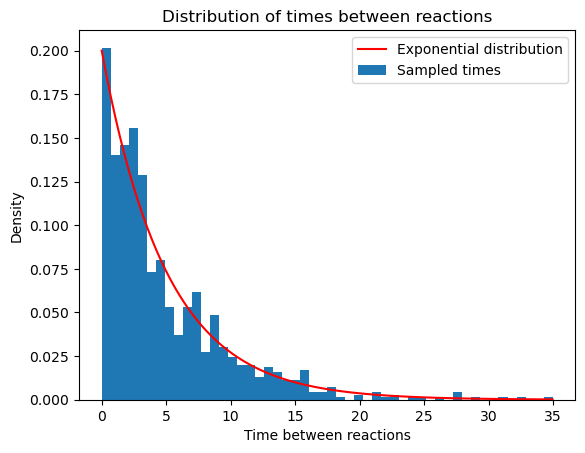

In [33]:
# Now that we defined that function, let's sample from it to get the distribution of times between reactions:

x0 = np.array([1, 0, 0])  # Initial conditions
times = []
for i in range(1000):
    times.append(next_time(x0, 0, pars))

# Plot the results of our samples as a histogram:
plt.hist(times, bins=50, density=True)
# Plot the analytical exponential distribution
t = np.linspace(0, max(times), 100)
lam = np.sum(W(x0, 0, pars))
plt.plot(t, lam*np.exp(-lam*t), 'r')

plt.xlabel('Time between reactions')
plt.ylabel('Density')
plt.title('Distribution of times between reactions')
plt.legend(['Exponential distribution', 'Sampled times'])
plt.show()

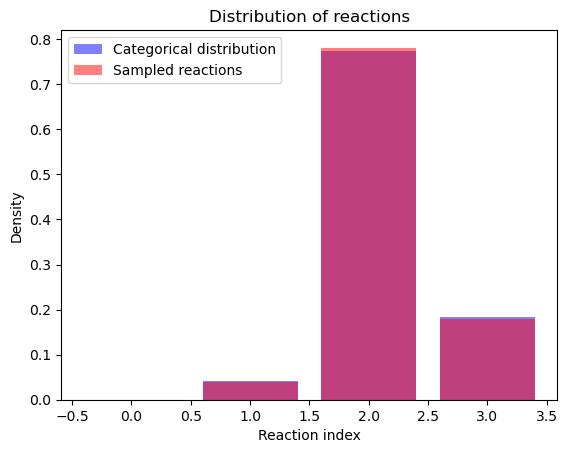

In [34]:
# Let's do the same for the categorical distribution of reactions:
x0 = np.array([0, 1, 23])  # Initial conditions
reactions = []
for i in range(1000):
    reactions.append(next_reaction(x0, 0, pars))

sampleHist = [sum([1 for i in reactions if i == j]) for j in range(4)]
# Plot the results of our samples as a bar plot:
plt.bar(range(4), sampleHist / np.sum(sampleHist), alpha=0.5, color='b')
truedist = (W(x0, 0, pars) / np.sum(W(x0, 0, pars))).flatten()
plt.bar(range(4), truedist, alpha=0.5, color='r')
plt.xlabel('Reaction index')
plt.ylabel('Density')
plt.title('Distribution of reactions')
plt.legend(['Categorical distribution', 'Sampled reactions'])
plt.show()

### Running the Gillespie Algorithm

In [35]:
# Now that we have codes that compute the next time and the next reaction, let's combine them
# to create the Gillespie algorithm. 

def gillespie0(x0, t0, tmax, S, pars, returnFullTraj = False):
    # Initialize the time and the state
    t = t0
    x = x0
    
    # Initialize the output (if requested)
    if returnFullTraj:
        times = [t0]
        states = [x0]
    
    # Run the simulation
    while t < tmax:
        # Compute the time of the next reaction
        tau = next_time(x, t, pars)
        t += tau
        
        # Exit the loop if the next reaction is beyond tmax
        if t > tmax:
            break
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, pars)

        # Update the state
        x = x + S[:, i]
        
        # Append the results (if requested)
        if returnFullTraj:
            times.append(t)
            states.append(x)

    # Return the results
    if returnFullTraj:
        # Return the full trajectory
        return np.array(times), np.array(states)
    else:
        # Return only the final state
        return x

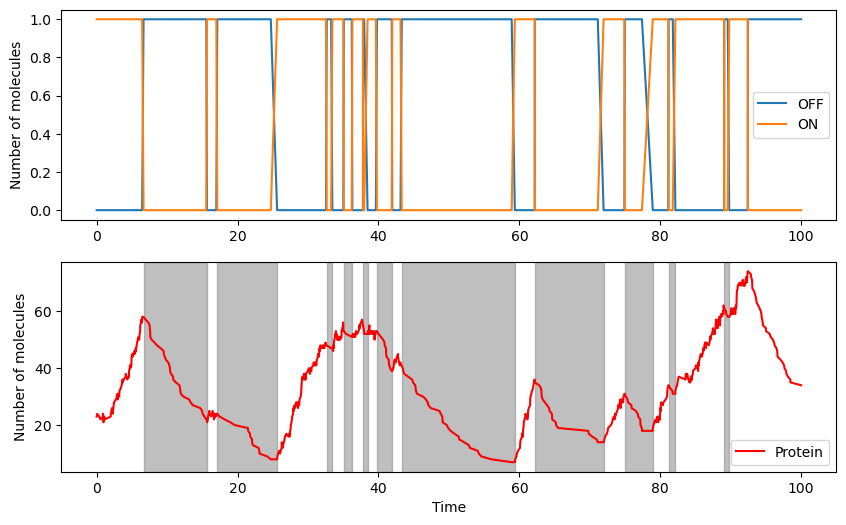

In [36]:
# Let's run the Gillespie algorithm for a long time and plot the results:
tmax = 100
times, states = gillespie0(x0, 0, tmax, S, pars, returnFullTraj=True)

# Plot the results in two subplots. The first subplot shows the number of 'OFF' and 'ON' molecules,
# and the second subplot shows the number of 'Protein' molecules.
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(times, states[:, 0], label='OFF')
ax[0].plot(times, states[:, 1], label='ON')
ax[0].set_ylabel('Number of molecules')
ax[0].legend()

ax[1].plot(times, states[:, 2], label='Protein', color='r')
# shade the region where the on state is active
active = states[:, 1] > 0
activeLims = []
for i in range(1,len(active)):
    if active[i-1]!=active[i]:
        activeLims.append(i)
for i in range(0,len(activeLims)-1,2):
    ax[1].axvspan(times[activeLims[i]], times[activeLims[i+1]], color='gray', alpha=0.5)
ax[1].set_ylabel('Number of molecules')
ax[1].legend()
plt.xlabel('Time')
plt.show()

### Running Many SSA trajectories to Collect Statistics
![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎019.png)

In [37]:
# Now, let's run the Gillespie algorithm multiple times and plot the results. 
# To save time, we will only save the final state of each trajectory. furthermore, we 
# will only plot the distribution of protein counts.
ntraj = 1000
tmax = 100

# Initialize the results
results = []
for i in range(ntraj):
    results.append(gillespie0(x0, 0, tmax, S, pars, returnFullTraj=False)[2])

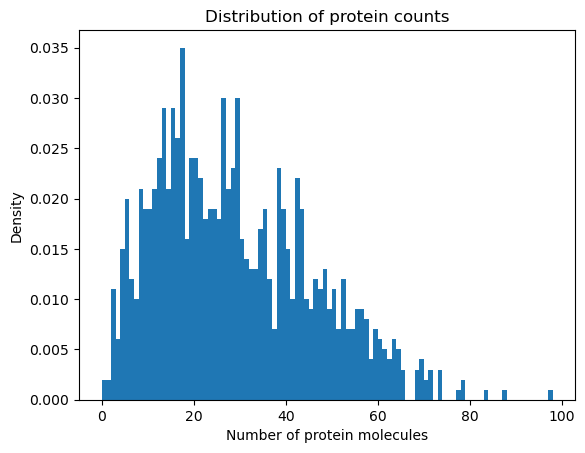

In [38]:
# Plot the results for the protein counts as a histogram
plt.hist(results, bins=range(max(results)+1), density=True)
plt.xlabel('Number of protein molecules')
plt.ylabel('Density')
plt.title('Distribution of protein counts')
plt.show()

In [39]:
# Let's adjust our Gillespie algorithm to return the trajectories at specific time points.

def gillespie1(x0, t0, tmax, S, pars, trajectoryTimes = None):
    # If the user did not provide specific time points, we will use the default
    if trajectoryTimes is None:
        trajectoryTimes = np.linspace(t0, tmax, 20)
    
    # Initialize the time and the state
    t = t0
    x = x0
     
    # Initialize the output
    states = np.zeros((len(trajectoryTimes), len(x0)))

    # next time index
    nextTimeIndex = 0

    # Run the simulation
    while t < tmax:
        # Compute the time of the next reaction
        tau = next_time(x, t, pars)
        t += tau
        
        # Check to see if we need to save the state
        while t >= trajectoryTimes[nextTimeIndex]:
            states[nextTimeIndex] = x
            nextTimeIndex += 1
            if nextTimeIndex >= len(trajectoryTimes):
                return states
        
        # Compute the index of the next reaction
        i = next_reaction(x, t, pars)

        # Update the state
        x = x + S[:, i]

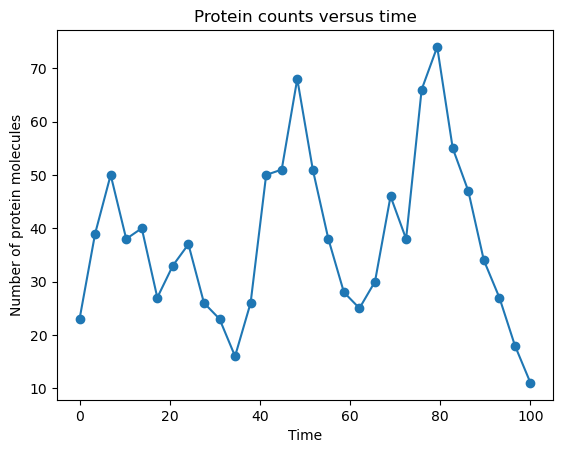

In [40]:
# Let's run the newer Gillespie algorithm and plot the results for protein counts versus time.
tmax = 100
trajectoryTimes = np.linspace(0, tmax, 30)
states = gillespie1(x0, 0, tmax, S, pars, trajectoryTimes)

# Plot the results for the protein counts
plt.plot(trajectoryTimes, states[:, 2], marker='o')
plt.xlabel('Time')
plt.ylabel('Number of protein molecules')
plt.title('Protein counts versus time')
plt.show()


{'kon': 0.2, 'koff': 0.5, 'kP': 10, 'gam': 0.1}


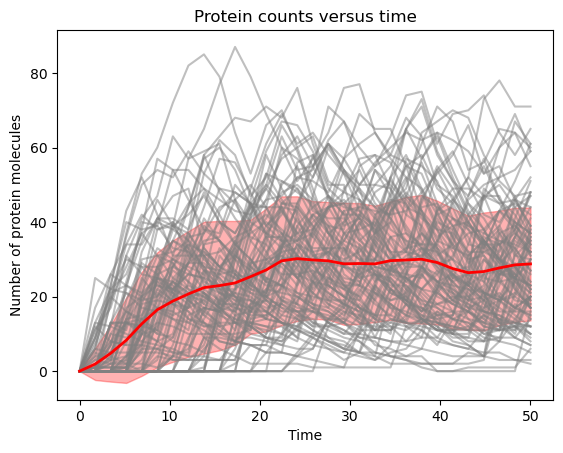

In [41]:
# Now, let's run the newer Gillespie algorithm multiple times and plot the results for protein counts
# all on the same plot.  We will also plot the mean and standard deviation of the protein counts.

print(pars)
x0 = np.array([1, 0, 0])
ntraj = 100
tmax = 50
trajectoryTimes = np.linspace(0, tmax, 30)

# Initialize the results
results = np.zeros((ntraj, len(trajectoryTimes)))
for i in range(ntraj):
    results[i] = gillespie1(x0, 0, tmax, S, pars, trajectoryTimes)[:, 2]

# Plot the results for the protein counts
plt.plot(trajectoryTimes, results.T, color='gray', alpha=0.5)
plt.plot(trajectoryTimes, np.mean(results, axis=0), color='r', linewidth=2)
plt.fill_between(trajectoryTimes, np.mean(results, axis=0) - np.std(results, axis=0), np.mean(results, axis=0) + np.std(results, axis=0), color='r', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Number of protein molecules')
plt.title('Protein counts versus time')
plt.show()


30


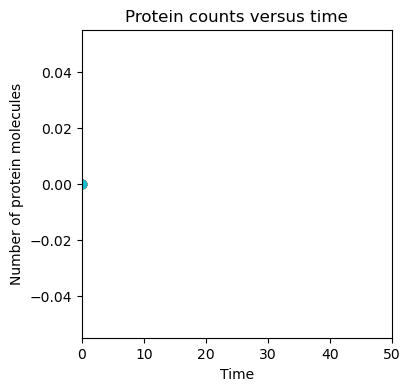

In [59]:
print(len(trajectoryTimes))
# Let's remake the above plot using an animation to show it as a function of time.
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(trajectoryTimes[:20], results.T[:20,:], color='gray', alpha=0.5)
def frame(iFrame):
    ax.cla()
    ax.plot(trajectoryTimes[:iFrame+1], results.T[:iFrame+1,:20], color='gray', alpha=0.5)
    for k in range(20):
        ax.plot(trajectoryTimes[iFrame], results.T[iFrame,k], 'o')
    ax.plot(trajectoryTimes[:iFrame+1], np.mean(results, axis=0)[:iFrame+1], color='r', linewidth=2)
    ax.fill_between(trajectoryTimes[:iFrame+1], np.mean(results, axis=0)[:iFrame+1] - np.std(results, axis=0)[:iFrame+1], np.mean(results, axis=0)[:iFrame+1] + np.std(results, axis=0)[:iFrame+1], color='r', alpha=0.3)
    ax.set_xlabel('Time')
    ax.set_xlim([0, tmax])
    ax.set_ylabel('Number of protein molecules')
    ax.set_title('Protein counts versus time')
    return fig
anim = animation.FuncAnimation(fig, frame, frames=len(trajectoryTimes), blit=False, repeat=False)
anim

### Comparing results of stochastic simulation to the deterministic ODE analysis.

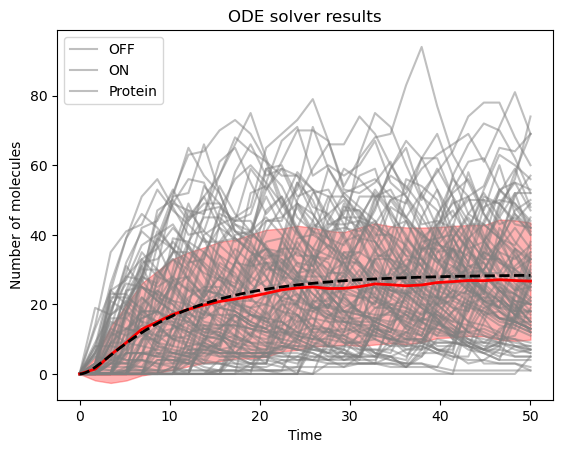

In [13]:
# Now, compare the results of the Gillespie algorithm with the results of the ODE solver from the previous module.
# Let's run the ODE solver for the same parameters and initial conditions.

def ODEmodel(x, t, pars):
    return np.dot(S, W(x, t, pars)).flatten()

t = np.linspace(0, tmax, 1000)
x = odeint(ODEmodel, x0, t, args=(pars,))

# Plot the previous SSA results
plt.plot(trajectoryTimes, results.T, color='gray', alpha=0.5)
plt.plot(trajectoryTimes, np.mean(results, axis=0), color='r', linewidth=2)
plt.fill_between(trajectoryTimes, np.mean(results, axis=0) - np.std(results, axis=0), np.mean(results, axis=0) + np.std(results, axis=0), color='r', alpha=0.3)

# Add the ODE solution as a thick black dashed line.
plt.plot(t, x[:,2], 'k--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Number of molecules')
plt.title('ODE solver results')
plt.legend(['OFF', 'ON', 'Protein'])
plt.show()

## Example - Michaelis-Menten Enzyme Kinetics
![alt text](Figures/StoichiometryAndPropensity_2023/Slide23b.png)

In [14]:
# Here we use the Gillespie Algorithm to model the Michaelis-Menten reaction.  
# The reaction rates and mechanisms for this model are copied from the previous module.

# Step 1: The number of species is 4: 'E', 'S', 'ES', 'P'
#         The initial conditions are:  x0 = [100, 1000, 0, 0]
#         The initial condition corresponds to 100 molecules of 'E' and 'S' and 0 molecules of 'ES' and 'P'
#         The initial condition is defined as a 4 x 1 numpy array:
x0 = np.array([100, 1000, 0, 0])

# Step 2: The number of reactions is 4:
#         R1:  E + S -> ES
#         R2:  ES -> E + S
#         R3:  ES -> E + P
#         R4:  P -> null

# Step 3: The stoichiometry matrix is a 4 x 4 matrix:
#         Rows correspond to species and columns correspond to reactions.
#         The matrix is defined as follows:
S = np.array([[-1, 1, 1, 0],
        [-1, 1, 0, 0],
        [1, -1, -1, 0],
        [0, 0, 1, -1]])

# Step 4: Define the reaction rate parameters as a dictionary
pars = {'k1': 0.01, 'k2': 0.5, 'k3': 0.05, 'k4': 0.01}
def W(x,t,pars=pars):
  return np.array([[pars['k1']*x[0]*x[1]],
                   [pars['k2']*x[2]],
                   [pars['k3']*x[2]],
                   [pars['k4']*x[3]]])

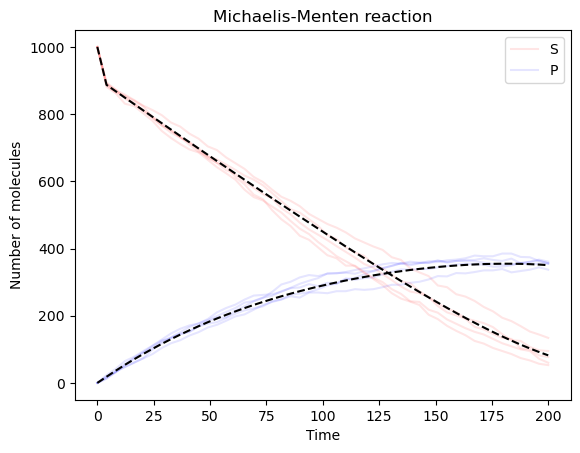

In [15]:
# Now, let's run the Gillespie algorithm for the Michaelis-Menten reaction and plot the results.
tmax = 200
trajectoryTimes = np.linspace(0, tmax, 50)

for i in range(5):
    states = gillespie1(x0, 0, tmax, S, pars, trajectoryTimes)
    # Plot the results for the substrate and protein counts
    plt.plot(trajectoryTimes, states[:, 1], color='r', alpha=0.1)
    plt.plot(trajectoryTimes, states[:, 3], color='b', alpha=0.1)

# Compare to the ODE solution
def ODEmodel(x, t, pars):
    return np.dot(S, W(x, t, pars)).flatten()
odeSoln = odeint(ODEmodel, x0, trajectoryTimes, args=(pars,))
plt.plot(trajectoryTimes, odeSoln[:,1], 'k--')
plt.plot(trajectoryTimes, odeSoln[:,3], 'k--')

plt.xlabel('Time')
plt.ylabel('Number of molecules')
plt.title('Michaelis-Menten reaction')
plt.legend(['S', 'P'])


## Example -- Genetic Toggle Switch
![alt text](Figures/StoichiometryAndPropensity_2023/Slide32a.png)

In [16]:
# In this example, we will analyze the genetic toggle switch model using the Gillespie algorithm.
# The parameters and rates for this model are copied from the previous module.

# Step 1: The number of species is 2: 'LacI', 'LambdaCI'
#         The initial conditions are:  x0 = [10, 100]
#         The initial condition corresponds to 10 molecules of 'LacI' and 100 of 'LambdaCI'
#         The initial condition is defined as a 2 x 1 numpy array:
x0 = np.array([10, 100])

# Step 2: The number of reactions is 4:
#         R1:  null -> LacI
#         R2:  null -> LambdaCI
#         R3:  LacI -> null
#         R4:  LambdaCI -> null

# Step 3: The stoichiometry matrix is a 2 x 4 matrix:
#         Rows correspond to species and columns correspond to reactions.
#         The matrix is defined as follows:
S = np.array([[1, 0, -1, 0],
        [0, 1, 0, -1]])

# Step 4: Define the reaction rate parameters as a dictionary
pars = {'k11': 0.02, 'k12': 1.2, 'a1': 10, 'eta1': 2, 'gamma1':0.02,
        'k21': 0.02, 'k22': 1.2, 'a2': 10, 'eta2': 2, 'gamma2':0.02}
def W(x,t,pars=pars):
  return np.array([ [pars['k11'] + pars['k12']/(1+(x[1]/pars['a1'])**pars['eta1'])],
                    [pars['k21'] + pars['k22']/(1+(x[0]/pars['a2'])**pars['eta2'])],
                    [pars['gamma1']*x[0]],
                    [pars['gamma2']*x[1]]])          

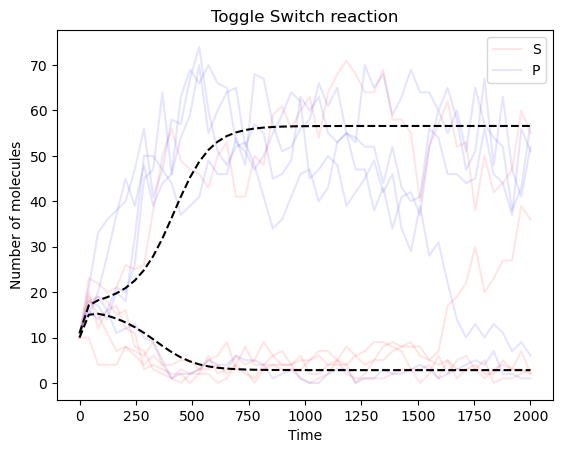

In [18]:
# Now, let's run the Gillespie algorithm for the toggle switch and plot the results.
x0 = np.array([10, 11])

tmax = 2000
trajectoryTimes = np.linspace(0, tmax, 50)

for i in range(5):
    states = gillespie1(x0, 0, tmax, S, pars, trajectoryTimes)
    # Plot the results for the substrate and protein counts
    plt.plot(trajectoryTimes, states[:, 0], color='r', alpha=0.1)
    plt.plot(trajectoryTimes, states[:, 1], color='b', alpha=0.1)

# Compare to the ODE solution
def ODEmodel(x, t, pars):
    return np.dot(S, W(x, t, pars)).flatten()
odeSoln = odeint(ODEmodel, x0, trajectoryTimes, args=(pars,))
plt.plot(trajectoryTimes, odeSoln[:,0], 'k--')
plt.plot(trajectoryTimes, odeSoln[:,1], 'k--')

plt.xlabel('Time')
plt.ylabel('Number of molecules')
plt.title('Toggle Switch reaction')
plt.legend(['S', 'P'])


In [19]:
# Example - Synthetic Oscillator
# In this example, we will analyze the synthetic oscillator model using the Gillespie algorithm.

# Step 1: The number of species is 3: 'A', 'B', 'C'
#         The initial conditions are:  x0 = [50, 5, 5]

# Step 2: The number of reactions is 6:
#         R1:  null -> A
#         R2:  A -> null
#         R3:  null -> B
#         R4:  B -> null
#         R5:  null -> C
#         R6:  C -> null

# Step 3: The stoichiometry matrix is a 3 x 6 matrix:
#         Rows correspond to species and columns correspond to reactions.
#         The matrix is defined as follows:
S = np.array([[1, -1, 0, 0, 0, 0],
        [0, 0, 1, -1, 0, 0],
        [0, 0, 0, 0, 1, -1]])

# Step 4: Define the reaction rate parameters as a dictionary
pars = {'k': 0.2, 'M': 10, 'eta': 3, 'gamma': 0.005}

def W(x,t,pars=pars):
    return np.array([[pars['k']/(1 + (x[2]/pars['M'])**pars['eta'])],
                     [pars['gamma']*x[0]],
                     [pars['k']/(1 + (x[0]/pars['M'])**pars['eta'])],
                     [pars['gamma']*x[1]],
                     [pars['k']/(1 + (x[1]/pars['M'])**pars['eta'])],
                     [pars['gamma']*x[2]]])

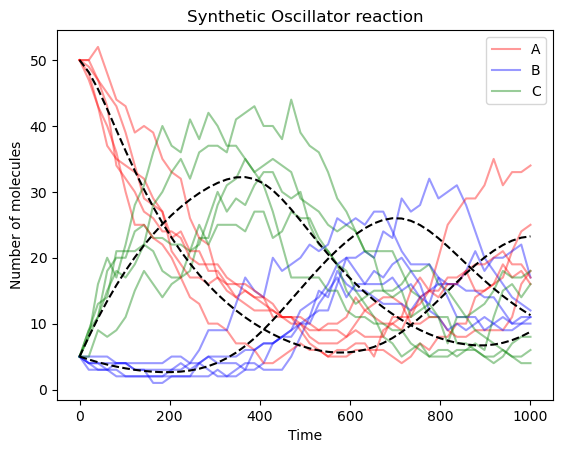

In [20]:
# Now, let's run the Gillespie algorithm for the synthetic oscillator and plot the results.
x0 = np.array([50, 5, 5])

tmax = 1000
trajectoryTimes = np.linspace(0, tmax, 50)

for i in range(5):
    states = gillespie1(x0, 0, tmax, S, pars, trajectoryTimes)
    # Plot the results for the substrate and protein counts
    plt.plot(trajectoryTimes, states[:, 0], color='r', alpha=0.4)
    plt.plot(trajectoryTimes, states[:, 1], color='b', alpha=0.4)
    plt.plot(trajectoryTimes, states[:, 2], color='g', alpha=0.4)

# Compare to the ODE solution
def ODEmodel(x, t, pars):
    return np.dot(S, W(x, t, pars)).flatten()
odeSoln = odeint(ODEmodel, x0, trajectoryTimes, args=(pars,))
plt.plot(trajectoryTimes, odeSoln[:,0], 'k--')
plt.plot(trajectoryTimes, odeSoln[:,1], 'k--')
plt.plot(trajectoryTimes, odeSoln[:,2], 'k--')

plt.xlabel('Time')
plt.ylabel('Number of molecules')
plt.title('Synthetic Oscillator reaction')
plt.legend(['A', 'B', 'C'])

plt.show()


# Importance of System Size (i.e., reactor volume).

Discrete Stochastic Noise is strongly affected by the the volume in which the chemical reaction is occurring. 

For a given concentration, large volumes will correspond to large numbers of molecules, at which the law of large numbers will smooth out small deviations.  But very small volumes (e.g., the size of a cell) could lead to very small numbers of molecules.  At the extreme, we may deal with situations where there are on average only one (or even fewer) molecule per cell.  In this case, a single molecule event can make a huge relative difference.

Let's see how that affects the response of the genetic toggle switch.

We will define the concentration:
$C_1 = x_1/\Omega$,
where $\Omega$ is the volume.  

To keep the propensity functions on the correct scale, we will define them as:
$w'_i(c) = w_i(x/\Omega)$

Let's see how that affects our results.


In [21]:
# In this example, we extend the toggle switch model to have a term that corresponds to the
# volume of the cell.  The parameters and rates for this model are copied from the previous module,
# but the rates are adjusted to account for the volume of the cell.

# Step 1: The number of species is 2: 'LacI', 'LambdaCI'
#         The initial conditions are:  x0 = [10, 100]
#         The initial condition corresponds to 10 molecules of 'LacI' and 100 of 'LambdaCI'
#         The initial condition is defined as a 2 x 1 numpy array:
x0 = np.array([10, 100])

# Step 2: The number of reactions is 4:
#         R1:  null -> LacI
#         R2:  null -> LambdaCI
#         R3:  LacI -> null
#         R4:  LambdaCI -> null

# Step 3: The stoichiometry matrix is a 2 x 4 matrix:
#         Rows correspond to species and columns correspond to reactions.
#         The matrix is defined as follows:
S = np.array([[1, 0, -1, 0],
        [0, 1, 0, -1]])

# Step 4: Define the reaction rate parameters as a dictionary
pars = {'k11': 0.02, 'k12': 1.2, 'a1': 10, 'eta1': 2, 'gamma1':0.02,
        'k21': 0.02, 'k22': 1.2, 'a2': 10, 'eta2': 2, 'gamma2':0.02,
        'V':1}
def W(x,t,pars=pars):
  return np.array([ [pars['V']*(pars['k11'] + pars['k12']/(1+((x[1]/pars['V'])/pars['a1'])**pars['eta1']))],
                    [pars['V']*(pars['k21'] + pars['k22']/(1+((x[0]/pars['V'])/pars['a2'])**pars['eta2']))],
                    [pars['V']*pars['gamma1']*x[0]/pars['V']],
                    [pars['V']*pars['gamma2']*x[1]/pars['V']]])          

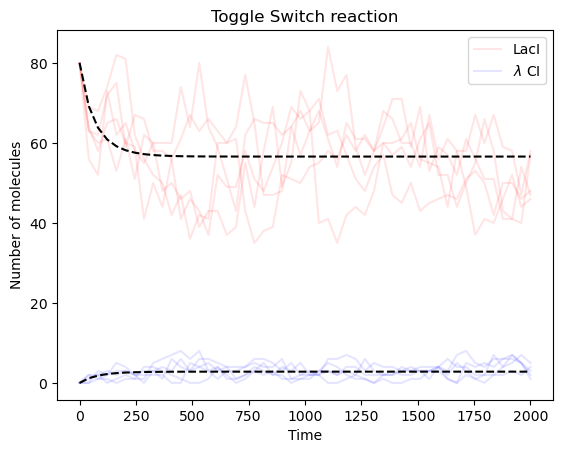

In [23]:
# Now, let's run the Gillespie algorithm for the toggle switch and plot the results.
tmax = 2000
trajectoryTimes = np.linspace(0, tmax, 50)

pars['V'] = 1  # Try values of 0.1, 0.3, 1, 3, 10
x0 = np.array([int(80*pars['V']), 0])

for i in range(5):
    states = gillespie1(x0, 0, tmax, S, pars, trajectoryTimes)
    # Plot the results for the substrate and protein counts
    plt.plot(trajectoryTimes, states[:, 0]/pars['V'], color='r', alpha=0.1)
    plt.plot(trajectoryTimes, states[:, 1]/pars['V'], color='b', alpha=0.1)

# Compare to the ODE solution
def ODEmodel(x, t, pars):
    return np.dot(S, W(x, t, pars)).flatten()
odeSoln = odeint(ODEmodel, x0, trajectoryTimes, args=(pars,))
plt.plot(trajectoryTimes, odeSoln[:,0]/pars['V'], 'k--')
plt.plot(trajectoryTimes, odeSoln[:,1]/pars['V'], 'k--')

plt.xlabel('Time')
plt.ylabel('Number of molecules')
plt.title('Toggle Switch reaction')
plt.legend(['LacI', '$\lambda$ CI'])

# Including Extrinsic Noise in Models
![alt text](Figures/StochasticSimulationAlgorithm/‎StochasticSimulationAlgorithm.‎020.png)

In [24]:
# Let's build a simple model of two promoters in the same cell that control two different genes.

# Step 1: The number of species is 2: 'G1', 'G2'
#         The initial conditions are:  x0 = [0, 0]

# Step 2: The number of reactions is 4:
#         R1:  null -> G1
#         R2:  null -> G2
#         R3:  G1 -> null
#         R4:  G2 -> null

# Step 3: The stoichiometry matrix is a 2 x 4 matrix:
S = np.array([[1, 0, -1, 0],
                [0, 1, 0, -1]])

# Step 4: Define the reaction rate parameters as a dictionary
parsBase = {'gamma1': 0.01, 'gamma2': 0.01}
def W(x,t,pars=pars):
  return np.array([[pars['k1']],
                   [pars['k2']],
                   [pars['gamma1']*x[0]],
                   [pars['gamma2']*x[1]]])

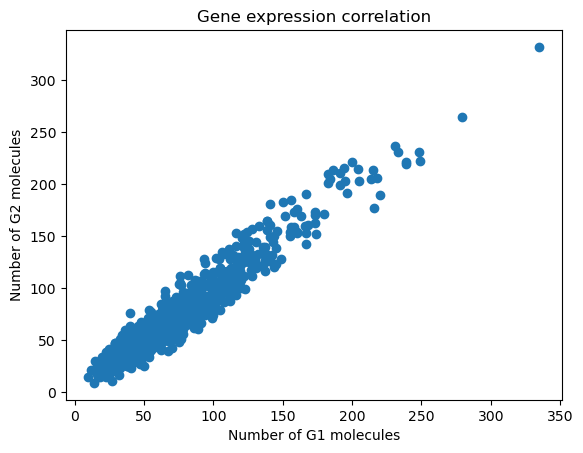

Correlation coefficient: 0.9604880756060046


In [35]:

nCells = 1000
x0 = np.array([0, 0])
noiseStrength = 0.05
trajectoryTimes = np.linspace(0, 100, 50)

finalValues = np.zeros((nCells, 2))
for i in range(nCells):
    pars = parsBase.copy()
    
    # We are going to use a log-normal distribution to introduce this variability.
    extrNoise = np.random.lognormal(0, noiseStrength)
    pars['k1'] = 1 * extrNoise
    pars['k2'] = 1 * extrNoise
    
    # Run the SSA to get the final values
    finalValues[i,:] = gillespie0(x0, 0, 100, S, pars, returnFullTraj=False)

# Plot the results for the protein counts as a scatter plot
plt.scatter(finalValues[:,0], finalValues[:,1])

# Compute and display the correlation coefficient
plt.xlabel('Number of G1 molecules')
plt.ylabel('Number of G2 molecules')
plt.title('Gene expression correlation')
plt.show()

corr = np.corrcoef(finalValues.T)
print('Correlation coefficient:', corr[0,1])